Data Loading

In [10]:
import zipfile
import os
# Paths to uploaded ZIP files
horror_zip = "/content/Horrer Video Stimulation.zip"
relaxing_zip = "/content/Participants Listening to Relaxing Music.zip"
# Output folders
horror_path = "/content/horror_data/Horrer Video Stimulation/Horrer Video Stimulation"
relaxing_path = "/content/relaxing_data/Participants Listening to Relaxing Music/Participants Listening to Relaxing Music"
os.makedirs(horror_path, exist_ok=True)
os.makedirs(relaxing_path, exist_ok=True)
# Function to unzip with progress printing
def extract_zip(zip_path, output_path, label):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        files = zip_ref.namelist()
        print(f"Unzipping {label}... ({len(files)} files)")
        for i, file in enumerate(files):
            zip_ref.extract(file, output_path)
            if i % 5 == 0:
                print(f"Extracted {i+1}/{len(files)}: {file}")
# Unzip horror dataset
extract_zip(horror_zip, horror_path, label="Horror")
# Unzip relaxing dataset
extract_zip(relaxing_zip, relaxing_path, label="Relaxing")
# Confirm extraction
print("\nHorror folder sample:", os.listdir(horror_path)[:5])
print("Relaxing folder sample:", os.listdir(relaxing_path)[:5])


Unzipping Horror... (46 files)
Extracted 1/46: Horrer Video Stimulation/
Extracted 6/46: __MACOSX/Horrer Video Stimulation/._002 (15).edf
Extracted 11/46: Horrer Video Stimulation/002 (18).edf
Extracted 16/46: __MACOSX/Horrer Video Stimulation/._002 (3).edf
Extracted 21/46: Horrer Video Stimulation/002 (13).edf
Extracted 26/46: __MACOSX/Horrer Video Stimulation/._002 (5).edf
Extracted 31/46: Horrer Video Stimulation/002 (6).edf
Extracted 36/46: __MACOSX/Horrer Video Stimulation/._002 (10).edf
Extracted 41/46: Horrer Video Stimulation/002 (20).edf
Extracted 46/46: __MACOSX/Horrer Video Stimulation/._002 (16).edf
Unzipping Relaxing... (42 files)
Extracted 1/42: Participants Listening to Relaxing Music/
Extracted 6/42: __MACOSX/Participants Listening to Relaxing Music/._001 (10).edf
Extracted 11/42: Participants Listening to Relaxing Music/001 (11).edf
Extracted 16/42: __MACOSX/Participants Listening to Relaxing Music/._001 (16).edf
Extracted 21/42: Participants Listening to Relaxing Musi

Installing mne and importing libraries

In [11]:
!pip install mne
import os
import numpy as np
import mne
from scipy.stats import entropy
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix
import glob

EEG Channel Selection and Hjorth Parameter

In [12]:
eeg_channels = ['AF3', 'AF4', 'T7', 'T8', 'Pz']

def compute_hjorth_parameters(signal):
    first_deriv = np.diff(signal)
    second_deriv = np.diff(first_deriv)
    var_zero = np.var(signal)
    var_d1 = np.var(first_deriv)
    var_d2 = np.var(second_deriv)

    activity = var_zero
    mobility = np.sqrt(var_d1 / var_zero) if var_zero > 0 else 0
    complexity = (np.sqrt(var_d2 / var_d1) / mobility) if var_d1 > 0 and mobility > 0 else 0
    return activity, mobility, complexity


Feature Extraction

In [13]:
def extract_features_from_folder(folder_path, label):
    X, y = [], []
    files = sorted(glob.glob(os.path.join(folder_path, "**/*.edf"), recursive=True))
    print(f"Found {len(files)} files in {folder_path}")

    for fname in files:
        try:
            raw = mne.io.read_raw_edf(os.path.join(folder_path, fname), preload=True, verbose=False)
            raw = raw.copy().pick([ch for ch in eeg_channels if ch in raw.ch_names])

            if len(raw.ch_names) < 3:
                print(f"Skipping {fname} due to insufficient channels.")
                continue

            psds = raw.compute_psd(fmin=8, fmax=30).get_data()
            mean_psd = np.mean(psds, axis=1)
            var_psd = np.var(psds, axis=1)
            entropies = np.array([entropy(ch) for ch in psds])
            hjorths = np.array([compute_hjorth_parameters(ch) for ch in psds]).flatten()

            features = np.concatenate([mean_psd, var_psd, entropies, hjorths])
            X.append(features)
            y.append(label)
        except Exception as e:
            print(f"Error reading {fname}: {e}")
    return X, y


Load and process data

In [14]:
X_horror, y_horror = extract_features_from_folder(horror_path, label=1)
X_relax, y_relax = extract_features_from_folder(relaxing_path, label=0)
X = np.array(X_horror + X_relax)
y = np.array(y_horror + y_relax)
print(f"\nFeature matrix shape: {X.shape}, Labels: {len(y)}")

Found 22 files in /content/horror_data/Horrer Video Stimulation/Horrer Video Stimulation
Effective window size : 16.000 (s)
Effective window size : 16.000 (s)
Effective window size : 16.000 (s)
Effective window size : 16.000 (s)
Effective window size : 16.000 (s)
Effective window size : 16.000 (s)
Effective window size : 16.000 (s)
Effective window size : 16.000 (s)
Effective window size : 16.000 (s)
Effective window size : 16.000 (s)
Effective window size : 16.000 (s)
Effective window size : 16.000 (s)
Effective window size : 16.000 (s)
Effective window size : 16.000 (s)
Effective window size : 16.000 (s)
Effective window size : 16.000 (s)
Effective window size : 16.000 (s)
Effective window size : 16.000 (s)
Effective window size : 16.000 (s)
Effective window size : 16.000 (s)
Effective window size : 16.000 (s)
Effective window size : 16.000 (s)
Found 20 files in /content/relaxing_data/Participants Listening to Relaxing Music/Participants Listening to Relaxing Music
Effective window s

Classifier ensemble

In [15]:
rf = RandomForestClassifier(random_state=42)
xgb = XGBClassifier(eval_metric='logloss')
knn = KNeighborsClassifier()
ensemble = VotingClassifier(estimators=[
    ('rf', rf),
    ('xgb', xgb),
    ('knn', knn)
], voting='soft')
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', ensemble)
])

1. Stratified K-Fold Cross Validation

In [20]:
print("\n3-Fold Stratified Cross-Validation")
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
scores_3fold = cross_val_score(pipeline, X, y, cv=skf, scoring='accuracy')
for i, score in enumerate(scores_3fold, 1):
    print(f"Fold {i}: {score:.2f}")
print(f"Average 3-Fold Accuracy: {scores_3fold.mean():.2f}")


3-Fold Stratified Cross-Validation
Fold 1: 0.86
Fold 2: 0.86
Fold 3: 0.57
Average 3-Fold Accuracy: 0.76


 Holdout Evaluation (80/20 split)

In [27]:
print("\n80/20 Holdout Evaluation")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


80/20 Holdout Evaluation
Confusion Matrix:
 [[3 1]
 [1 4]]
Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.75      0.75         4
           1       0.80      0.80      0.80         5

    accuracy                           0.78         9
   macro avg       0.78      0.78      0.78         9
weighted avg       0.78      0.78      0.78         9



GridSearch on XGBoost parameters

In [28]:
print("\nGridSearchCV on XGBoost")
param_grid = {
    'clf__xgb__learning_rate': [0.05, 0.1],
    'clf__xgb__max_depth': [3, 5]
}
grid = GridSearchCV(pipeline, param_grid, cv=3, scoring='accuracy')
grid.fit(X, y)
print("Best Parameters:", grid.best_params_)
print("Best GridSearch Accuracy:", grid.best_score_)



GridSearchCV on XGBoost
Best Parameters: {'clf__xgb__learning_rate': 0.05, 'clf__xgb__max_depth': 3}
Best GridSearch Accuracy: 0.7380952380952381


Repeated CV with different seeds

In [29]:
print("\nRepeated Stratified K-Fold (5 Seeds)")
seeds = [10, 20, 42, 77, 99]
avg_scores = []
for seed in seeds:
    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=seed)
    score = cross_val_score(pipeline, X, y, cv=skf, scoring='accuracy').mean()
    print(f"Seed {seed}: Accuracy = {score:.2f}")
    avg_scores.append(score)

print(f"\nFinal Averaged Accuracy Across Seeds: {np.mean(avg_scores):.2f}")



Repeated Stratified K-Fold (5 Seeds)
Seed 10: Accuracy = 0.79
Seed 20: Accuracy = 0.76
Seed 42: Accuracy = 0.76
Seed 77: Accuracy = 0.69
Seed 99: Accuracy = 0.76

Final Averaged Accuracy Across Seeds: 0.75


<Figure size 600x500 with 0 Axes>

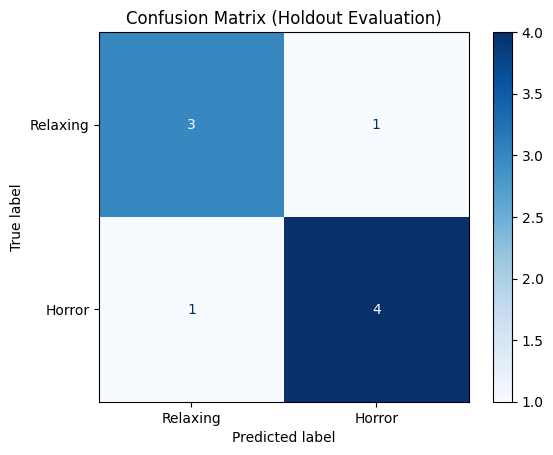

In [30]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Relaxing", "Horror"])
plt.figure(figsize=(6, 5))
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix (Holdout Evaluation)")
plt.show()